In [198]:
import numpy as np
import wandb

In [199]:
''' MLP class  '''
class MLP:
    ''' Multi-layer perceptron class '''
    ''' input_size, hidden_layers = [sizes of the hidden layers], output_size, epochs, learning_rate, batch_size, activation_function, loss_function '''
    def __init__(self, input_size, hidden_layers, output_size, epochs = 100, learning_rate = 0.01, early_stopping = True,
                 batch_size = 32, activation_function = 'relu', loss_function = 'mse', optimizer = 'sgd', beta = 0.0, 
                 Random_state = None, weight_init = 'he', model_type = 'class_ML', wandb_vaar = False, run_start = "hyperparam_tuning", wandb_finish = True):
        
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.early_stopping = early_stopping
        self.beta = beta
        self.weight_init = weight_init
        self.model_type = model_type
        self.wandb_vaar = wandb_vaar
        self.wandb_finish = wandb_finish
        
        self.weights = []
        self.biases = []
        self.loss = []
        self.history = []
        
        np.random.seed(Random_state)
        
        self._initialize_weights()
        
        run_name = f"{run_start}-{self.activation_function}-{self.optimizer}-{self.loss_function}-{self.weight_init}-{self.epochs}-{self.learning_rate}-{self.batch_size}"
        
        # Initialize WandB
        if wandb_vaar:
            wandb.init(
                project="SMAI_A3-MLP", 
                name=run_name,
                config={
                "learning_rate": self.learning_rate,
                "epochs": self.epochs,
                "batch_size": self.batch_size,
                "activation": self.activation_function,
                "optimizer": self.optimizer,
                "input_size": self.input_size,
                "hidden_layer_sizes": self.hidden_layers,
                "output_size": self.output_size,
                "loss_function": self.loss_function,
                "weight_init": self.weight_init,
                "Random_state": Random_state,
                "beta": self.beta,
                "early_stopping": self.early_stopping,
            })
        
    def _initialize_weights(self):
        ''' Initialize weights '''
        layers = [self.input_size] + self.hidden_layers + [self.output_size]
        for i in range(len(layers) - 1):
            if self.weight_init == 'random':
                self.weights.append(np.random.randn(layers[i], layers[i+1]))  # Random initialization
            
            elif self.weight_init == 'he':
                self.weights.append(np.random.randn(layers[i], layers[i+1]) * np.sqrt(2. / layers[i]))  # He initialization
            
            elif self.weight_init == 'xavier':
                limit = np.sqrt(6 / (layers[i] + layers[i+1]))
                self.weights.append(np.random.uniform(-limit, limit, (layers[i], layers[i+1])))  # Xavier/Glorot initialization
            
            self.biases.append(np.zeros(layers[i+1]))
        
        self.vW = [np.zeros_like(w) for w in self.weights]  # Initialize velocity for weights
        self.vb = [np.zeros_like(b) for b in self.biases]   # Initialize velocity for biases
    
    # Activation functions       
    def relu(self, x):
        ''' ReLU activation function '''
        return np.where(x > 0, x, x * 0.01)
    def relu_derivative(self, x):
        ''' ReLU derivative '''
        return np.where(x > 0, 1, 0.01)
    
    def sigmoid(self, x):
        ''' Sigmoid activation function '''
        return 1 / (1 + np.exp(-x))
    def sigmoid_derivative(self, x):
        ''' Sigmoid derivative '''
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def tanh(self, x):
        ''' Tanh activation function '''
        return np.tanh(x)
    def tanh_derivative(self, x):
        ''' Tanh derivative '''
        return 1 - np.tanh(x)**2
    
    def linear(self, x):
        ''' Linear activation function '''
        return x
    def linear_derivative(self, x):
        ''' Linear derivative '''
        return 1
            
    def _activation(self, activation_function = None):
        ''' Activation function '''
        if activation_function == 'relu':
            return self.relu, self.relu_derivative
        elif activation_function == 'sigmoid':
            return self.sigmoid, self.sigmoid_derivative
        elif activation_function == 'tanh':
            return self.tanh, self.tanh_derivative
        elif activation_function == 'linear':
            return self.linear, self.linear_derivative
        else:
            raise ValueError('Activation function not supported')
    
    # Optimizers
    def mse(self, y, y_pred):
        ''' Mean squared error '''
        return np.mean((y - y_pred)**2)
    def mse_derivative(self, y, y_pred):
        ''' Mean squared error derivative '''
        return 2*(y_pred - y)
    
    # Loss for regression
    def rmse(self, y, y_pred):
        ''' Root mean squared error '''
        return np.sqrt(np.mean((y - y_pred)**2))
    def mae(self, y, y_pred):
        ''' Mean absolute error '''
        return np.mean(np.abs(y - y_pred))
    def r_squared(self, y, y_pred):
        ''' R-squared metric '''
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        return 1 - (ss_res / ss_tot)
    
    def cross_entropy(self, y, y_pred):
        ''' Cross entropy loss '''
        return -np.sum(y * np.log(y_pred)) / len(y)
    
    def cross_entropy_derivative(self, y, y_pred):
        ''' Cross entropy derivative '''
        epsilon = 1e-15  # Small value to avoid division by zero
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        return (y_pred - y) / (y_pred * (1 - y_pred))
    
    def _loss(self):
        ''' Loss function '''
        if self.loss_function == 'mse':
            return self.mse, self.mse_derivative
        elif self.loss_function == 'cross_entropy':
            return self.cross_entropy, self.cross_entropy_derivative
        else:
            raise ValueError('Loss function not supported')
        
    def _softmax(self, x):
        ''' Softmax activation function '''
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def _one_hot(self, y):
        ''' One-hot encoding '''
        # print(y.min(), y.max())
        one_hot = np.zeros((y.size, y.max()+1- y.min()))
        for i in range(y.size):
            one_hot[i, y[i] - y.min()] = 1
        return one_hot
    
    def filter_onehot(self, y_true, y_test):
        y_true = np.argmax(y_true, axis=1)
        y_test = np.argmax(y_test, axis=1)
        return y_true, y_test
    
    def filter_softmax(self, y_pred):
        # if >0.5, then 1 else 0
        return np.where(y_pred > 0.5, 1, 0)
        
    
    def accuracy(self, y_true, y_pred):
        correct_predictions = np.sum(y_true == y_pred)
        total_predictions = len(y_true)
        return correct_predictions / total_predictions
    
    def hamming_loss(self, y_true, y_pred):
        # Compute the number of incorrectly predicted labels
        incorrect_labels = np.sum(y_true != y_pred)
        
        # Total number of labels is the number of samples times the number of labels per sample
        total_labels = y_true.shape[0] * y_true.shape[1]
        
        # Hamming Loss: Proportion of incorrect labels
        return incorrect_labels / total_labels
    
    def multi_label_partial_accuracy(self, y_true, y_pred):
        y_pred_partial = y_pred.reshape(-1, 1)
        y_true_partial = y_true.reshape(-1, 1)
        partial_accuracy = self.accuracy(y_true_partial, y_pred_partial)
        return partial_accuracy
    
    def multi_label_accuracy(self, y_true, y_pred):
        # Exact match accuracy (where all labels for a sample are correctly predicted)
        correct_predictions = np.sum(np.all(y_true == y_pred, axis=1))
        total_predictions = len(y_true)
        return correct_predictions / total_predictions
    
    def multi_label_confusion_matrix(self, y_true, y_pred):
        num_labels = y_true.shape[1]
        confusion_matrices = []

        for i in range(num_labels):
            tp = np.sum((y_pred[:, i] == 1) & (y_true[:, i] == 1))  # True Positive
            tn = np.sum((y_pred[:, i] == 0) & (y_true[:, i] == 0))  # True Negative
            fp = np.sum((y_pred[:, i] == 1) & (y_true[:, i] == 0))  # False Positive
            fn = np.sum((y_pred[:, i] == 0) & (y_true[:, i] == 1))  # False Negative

            matrix = np.array([[tn, fp], [fn, tp]])
            confusion_matrices.append(matrix)

        return np.array(confusion_matrices)
    
    def multi_label_micro_metrics_partial(self, y_true, y_pred):
        # confusion matrix
        confusion_matrix = self.multi_label_confusion_matrix(y_true, y_pred)

        # micro-averaged precision, recall, f1_score
        micro_precision = np.sum(confusion_matrix[:, 0, 0]) / np.sum(confusion_matrix[:, 0, 0] + np.sum(confusion_matrix[:, 1, 0] + 1e-6))
        micro_recall = np.sum(confusion_matrix[:, 0, 0]) / np.sum(confusion_matrix[:, 0, 0] + np.sum(confusion_matrix[:, 1, 1] + 1e-6))
        micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)
        
        return micro_precision, micro_recall, micro_f1_score
    
    def multi_label_macro_metrics_partial(self, y_true, y_pred):
        # confusion matrix
        confusion_matrix = self.multi_label_confusion_matrix(y_true, y_pred)

        # macro-averaged precision, recall, f1_score
        macro_precision = np.mean(confusion_matrix[:, 0, 0] / (confusion_matrix[:, 0, 0] + confusion_matrix[:, 1, 0] + 1e-6))
        macro_recall = np.mean(confusion_matrix[:, 0, 0] / (confusion_matrix[:, 0, 0] + confusion_matrix[:, 1, 1] + 1e-6))
        macro_f1_score = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall)
        
        return macro_precision, macro_recall, macro_f1_score
    
    def multi_label_precision_recall_f1(self, y_true, y_pred):
        epsilon = 1e-9  # To avoid division by zero

        # True Positives, False Positives, and False Negatives for each label
        true_positives = np.sum((y_pred == 1) & (y_true == 1), axis=0)
        false_positives = np.sum((y_pred == 1) & (y_true == 0), axis=0)
        false_negatives = np.sum((y_pred == 0) & (y_true == 1), axis=0)

        # Precision: TP / (TP + FP)
        precision = true_positives / (true_positives + false_positives + epsilon)
        
        # Recall: TP / (TP + FN)
        recall = true_positives / (true_positives + false_negatives + epsilon)
        
        # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
        f1 = 2 * (precision * recall) / (precision + recall + epsilon)

        # Return macro-average (mean over all labels)
        return precision, recall, f1
    
    def confusion_matrix(self, y_true, y_pred):
        classes = np.unique(y_true)
        matrix = np.zeros((len(classes), len(classes)), dtype=int)

        for i in range(len(y_true)):
            true_idx = np.where(classes == y_true[i])[0][0]
            pred_idx = np.where(classes == y_pred[i])[0][0]
            matrix[true_idx, pred_idx] += 1
        
        return matrix
    
    def recall(self, y_true, y_pred):
        matrix = self.confusion_matrix(y_true, y_pred)
        recall_values = np.diag(matrix) / np.sum(matrix, axis=1)  # TP / (TP + FN)
        recall_values = np.nan_to_num(recall_values)  # Handle division by zero
        return np.mean(recall_values)
    
    def precision(self, y_true, y_pred):
        matrix = self.confusion_matrix(y_true, y_pred)
        precision_values = np.diag(matrix) / np.sum(matrix, axis=0)  # TP / (TP + FP)
        precision_values = np.nan_to_num(precision_values)  # Handle division by zero
        return np.mean(precision_values)
    
    def f1_score(self, y_true, y_pred):
        prec = self.precision(y_true, y_pred)
        rec = self.recall(y_true, y_pred)
        if (prec + rec) == 0:
            return 0
        return 2 * (prec * rec) / (prec + rec)
    
    def model_functions(self):
        if self.model_type == 'class_ML':
            return self.sigmoid, self.sigmoid_derivative
        elif self.model_type == 'class_MC':
            return self._softmax, self.cross_entropy_derivative
        elif self.model_type == 'regression':
            return self._activation(self.activation_function)
    
    # Forward pass
    def forward(self, X):
        ''' Forward pass '''
        activations = [X]
        Z = [X]
        
        activation, _ = self._activation(self.activation_function)
        current_activation = X
        
        # Hidden layers
        for i in range(len(self.weights) - 1):
            z = np.dot(current_activation, self.weights[i]) + self.biases[i]
            Z.append(z)
            current_activation = activation(z)
            activations.append(current_activation)
            
        # Output layer
        z = np.dot(current_activation, self.weights[-1]) + self.biases[-1]
        Z.append(z)
        
        # Check if the model is for classification or regression
        activation_function, _ = self.model_functions()
        # output_activation = self.relu(z) # Output activation function
        output_activation = activation_function(z) # Output activation function
        activations.append(output_activation)
        self.activations = activations
        
        return Z, activations
    
    # Backward pass
    def backward(self, X, y, Z, activations):
        ''' Backward pass '''
        grads = {}
        m = y.shape[0]
        
        # Activation function
        # activation_function, activation_derivative = self._activation(self.activation_function)
        activation_function, activation_derivative = self.model_functions()
        
        # Loss function
        # loss, loss_derivative = self._loss()
        if self.model_type == 'class_ML':
            loss, loss_derivative = self.cross_entropy, self.cross_entropy_derivative
        elif self.model_type == 'class_MC':
            loss, loss_derivative = self.cross_entropy, self.cross_entropy_derivative
        elif self.model_type == 'regression':
            loss, loss_derivative = self.mse, self.mse_derivative
        
        # backprop loss in output layer
        dA = loss_derivative(y, (activations[-1]))
        if self.model_type == 'class_MC':
            dZ = (activations[-1] - y) / m
        else:
            dZ = dA * activation_derivative(Z[-1])
        
        grads["dW" + str(len(self.weights)-1)] = np.dot(activations[-2].T, dZ) / m
        grads["db" + str(len(self.weights)-1)] = np.sum(dZ, axis=0) / m
        
        # backprop hidden layers
        activation_function, activation_derivative = self._activation(self.activation_function)
        for i in range(len(self.weights)-2, -1, -1):
            dA = np.dot(dZ, self.weights[i+1].T)
            dZ = dA * activation_derivative(Z[i+1])
            grads["dW" + str(i)] = np.dot(activations[i].T, dZ) / m
            grads["db" + str(i)] = np.sum(dZ, axis=0) / m
            
        return grads
    
    # # Update weights
    # def update_weights(self, grads):
    #     ''' Update weights '''
    #     # print('weights:', len(self.weights))
    #     # for i in range(len(self.weights)):
    #     #     print(self.weights[i].shape, grads["dW" + str(i)].shape)
    #     for i in range(len(self.weights)):
    #         self.weights[i] -= self.learning_rate * grads["dW" + str(i)]
    #         self.biases[i] -= self.learning_rate * grads["db" + str(i)]
    
    # update weights using momentum
    def update_weights(self, grads):
        for i in range(len(self.weights)):
            # Update the velocity for weights and biases using momentum
            self.vW[i] = self.beta * self.vW[i] + (1 - self.beta) * grads["dW" + str(i)]
            self.vb[i] = self.beta * self.vb[i] + (1 - self.beta) * grads["db" + str(i)]
            
            # Update the weights and biases using velocity
            self.weights[i] -= self.learning_rate * self.vW[i]
            self.biases[i] -= self.learning_rate * self.vb[i]
            
    # Train the model
    def fit(self, X, y, X_val = None, y_val = None):
        # encode the target variable if it is not regression
        # if not self.model_type == 'regression':
        #     y = self._one_hot(y)
        
        ''' Train the model '''
        for epoch in range(self.epochs):
            self.optimize(X, y)
            
            # Loss
            loss_func, loss_derivative = self._loss()
            y_pred = self.forward(X)[1][-1] # Predictions
            self.loss.append(loss_func(y, y_pred))
            
            # Loss on validation set
            if X_val is not None and y_val is not None:
                y_pred_val = self.predict(X_val)
                self.history.append(loss_func(y_val, y_pred_val))
            
            # Log accuracy, recall, precision, f1_score
            if self.model_type == 'class_MC' and self.wandb_vaar:
                # train
                y_true, y_pred = self.filter_onehot(y, y_pred)
                accuracy = self.accuracy(y_true, y_pred)
                recall = self.recall(y_true, y_pred)
                precision = self.precision(y_true, y_pred)
                f1_score = self.f1_score(y_true, y_pred)
                # val
                y_true_val, y_pred_val = self.filter_onehot(y_val, y_pred_val)
                accuracy_val = self.accuracy(y_true_val, y_pred_val)
                recall_val = self.recall(y_true_val, y_pred_val)
                precision_val = self.precision(y_true_val, y_pred_val)
                f1_score_val = self.f1_score(y_true_val, y_pred_val)
            elif self.model_type == 'class_ML' and self.wandb_vaar:
                # train
                y_pred = self.filter_softmax(y_pred)
                accuracy = self.accuracy(y, y_pred)
                partial_accuracy = self.multi_label_partial_accuracy(y, y_pred)
                micro_precision, micro_recall, micro_f1_score = self.multi_label_micro_metrics_partial(y, y_pred)
                macro_precision, macro_recall, macro_f1_score = self.multi_label_macro_metrics_partial(y, y_pred)
                hamming_loss = self.hamming_loss(y, y_pred)
                multi_label_accuracy = self.multi_label_accuracy(y, y_pred)
                # val
                y_pred_val = self.filter_softmax(y_pred_val)
                accuracy_val = self.accuracy(y_val, y_pred_val)
                partial_accuracy_val = self.multi_label_partial_accuracy(y_val, y_pred_val)
                micro_precision_val, micro_recall_val, micro_f1_score_val = self.multi_label_micro_metrics_partial(y_val, y_pred_val)
                macro_precision_val, macro_recall_val, macro_f1_score_val = self.multi_label_macro_metrics_partial(y_val, y_pred_val)
                hamming_loss_val = self.hamming_loss(y_val, y_pred_val)
                multi_label_accuracy_val = self.multi_label_accuracy(y_val, y_pred_val)
            elif self.model_type == 'regression' and self.wandb_vaar:
                # train
                loss = self.mse(y, y_pred)
                r_squared = self.r_squared(y, y_pred)
                mean_absolute_error = self.mae(y, y_pred)
                # val
                loss_val = self.mse(y_val, y_pred_val)
                r_squared_val = self.r_squared(y_val, y_pred_val)
                mean_absolute_error_val = self.mae(y_val, y_pred_val)
                
            
            if self.wandb_vaar and self.wandb_vaar and self.model_type == 'class_MC':
                wandb.log({"epoch":epoch+1, "train/loss": self.loss[-1], "train/accuracy": accuracy, "train/recall": recall, "train/precision": precision, 
                    "train/f1_score": f1_score, "val/loss": self.history[-1], "val/accuracy": accuracy_val, "val/recall": recall_val, "val/precision": precision_val, 
                    "val/f1_score": f1_score_val})
            elif self.wandb_vaar and self.wandb_vaar and self.model_type == 'class_ML':
                wandb.log({"epoch":epoch+1, "train/loss": self.loss[-1], "train/accuracy": accuracy, "train/partial_accuracy": partial_accuracy, 
                    "train/micro_precision": micro_precision, "train/micro_recall": micro_recall, "train/micro_f1_score": micro_f1_score, 
                    "train/macro_precision": macro_precision, "train/macro_recall": macro_recall, "train/macro_f1_score": macro_f1_score, 
                    "train/hamming_loss": hamming_loss, "train/multi_label_accuracy": multi_label_accuracy, 
                    "val/loss": self.history[-1], "val/accuracy": accuracy_val, "val/partial_accuracy": partial_accuracy_val, 
                    "val/micro_precision": micro_precision_val, "val/micro_recall": micro_recall_val, "val/micro_f1_score": micro_f1_score_val, 
                    "val/macro_precision": macro_precision_val, "val/macro_recall": macro_recall_val, "val/macro_f1_score": macro_f1_score_val, 
                    "val/hamming_loss": hamming_loss_val, "val/multi_label_accuracy": multi_label_accuracy_val})
            elif self.wandb_vaar and self.model_type == 'regression':
                wandb.log({"epoch":epoch+1, "train/loss": self.loss[-1], "train/r_squared": r_squared, "train/mean_absolute_error": mean_absolute_error,
                           "val/loss": self.history[-1], "val/r_squared": r_squared_val, "val/mean_absolute_error": mean_absolute_error_val})
            # else:
            #     print(f"Loss: {self.loss[-1]}")
            
            if self.early_stopping:
                if len(self.loss) > 1 and abs(self.loss[-1] - self.loss[-2]) < 1e-6:
                    print(f"Converged after {epoch+1} epochs")
                    break
        
        if self.wandb_vaar and self.wandb_finish:
            wandb.finish()
            
    # Optimize
    def optimize(self, X, y):
        ''' Optimize the model '''
        if self.optimizer == 'sgd':
            self.sgd(X, y)
        elif self.optimizer == 'mini_batch':
            self.mini_batch(X, y)
        elif self.optimizer == 'full_batch':
            self.batch(X, y)
        else:
            raise ValueError('Optimizer not supported')
    
    def sgd(self, X, y):
        ''' Stochastic gradient descent '''
        for i in range(X.shape[0]):
            Z, activations = self.forward(X[i])
            
            # Adjust the sizes of matrix
            for j in range(len(activations)):
                activations[j] = activations[j].reshape(1, -1)
                Z[j] = Z[j].reshape(1, -1)
            
            grads = self.backward(X[i], y[i].reshape(1,-1), Z, activations)
            self.update_weights(grads)
    
    def mini_batch(self, X, y):
        ''' Mini-batch gradient descent '''
        for i in range(0, X.shape[0], self.batch_size):
            Z, activations = self.forward(X[i:i+self.batch_size])
            grads = self.backward(X[i:i+self.batch_size], y[i:i+self.batch_size], Z, activations)
            self.update_weights(grads)
            
    def batch(self, X, y):
        ''' Batch gradient descent '''
        Z, activations = self.forward(X)
        grads = self.backward(X, y, Z, activations)
        self.update_weights(grads)
        
    # Predict
    def predict(self, X):
        ''' Predict '''
        Z, activations = self.forward(X)
        return activations[-1]
    
    # Evaluate
    def evaluate(self, X, y):
        ''' Evaluate '''
        y_pred = self.predict(X)
        loss, _ = self._loss()
        return loss(y, y_pred)
    
    def _compute_loss(self, X, y):
        ''' Compute loss '''
        Z, activations = self.forward(X)
        loss, _ = self._loss()
        return loss(y, activations[-1])
    
    # gradient checks
    def check_gradients(self, X, y):
        ''' Gradient checks '''
        epsilon = 1e-4
        Z, activations = self.forward(X)
        grads = self.backward(X, y, Z, activations)
        
        numerical_grads_list = []
        analytical_grads_list = []
        
        # Check gradients
        for i in range(len(self.weights)):
            numerical_grads = np.zeros_like(self.weights[i])
            for j in range(self.weights[i].shape[0]):
                for k in range(self.weights[i].shape[1]):
                    self.weights[i][j, k] += epsilon
                    loss_plus = self._compute_loss(X, y)
                    
                    self.weights[i][j, k] -= 2 * epsilon
                    loss_minus = self._compute_loss(X, y)
                    
                    self.weights[i][j, k] += epsilon
                    
                    grad = (loss_plus - loss_minus) / (2 * epsilon)
                    numerical_grads[j, k] = grad
            
            # Compare gradients
            numerical_grads_list.extend(numerical_grads.ravel())
            analytical_grads_list.extend(grads["dW" + str(i)].ravel())
            
        # compare the difference between numerical and analytical gradients
        numerical_grads_list = np.array(numerical_grads_list)
        analytical_grads_list = np.array(analytical_grads_list)
        
        difference = np.linalg.norm(numerical_grads_list - analytical_grads_list) / \
            (np.linalg.norm(numerical_grads_list) + np.linalg.norm(analytical_grads_list))
            
        print(f"Gradient difference: {difference}")
        
        if difference < 1e-7 or difference == 0 or np.isnan(difference):
            print("Gradients are correct")        

In [200]:
import pandas as pd

# load the data
filepath = '../../data/interim/HousingData_Normalized.csv'

df = pd.read_csv(filepath)

X = df.drop('MEDV', axis=1).values
y = df['MEDV'].values
y = y.reshape(-1, 1)

print(X.shape, y.shape)

# shuffle the data
np.random.seed(0)

idx = np.random.permutation(len(X))

X = X[idx]
y = y[idx]

# split the data
X_train = X[:int(0.8*len(X))]
X_test = X[int(0.8*len(X)):int(0.9*len(X))]
X_val = X[int(0.9*len(X)):]
y_train = y[:int(0.8*len(y))]
y_test = y[int(0.8*len(y)):int(0.9*len(y))]
y_val = y[int(0.9*len(y)):]

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

# Initialize the model
mlp = MLP(input_size = X_train.shape[1], hidden_layers = [16, 16], output_size = 1, epochs = 1000, learning_rate = 0.01,batch_size=16,
            activation_function = 'relu', loss_function = 'mse', optimizer = 'mini_batch', Random_state = 0, weight_init = 'he', model_type = 'regression', wandb_vaar = False)

# Train the model
mlp.fit(X_train, y_train, X_val, y_val)

# Evaluate the model
loss = mlp.evaluate(X_test, y_test)

# check gradient
mlp.check_gradients(X_train, y_train)

print(f"Test loss: {loss}")


(506, 13) (506, 1)
(404, 13) (51, 13) (51, 13)
(404, 1) (51, 1) (51, 1)
Converged after 764 epochs
Gradient difference: 0.02139982341243285
Test loss: 0.007016173281803743


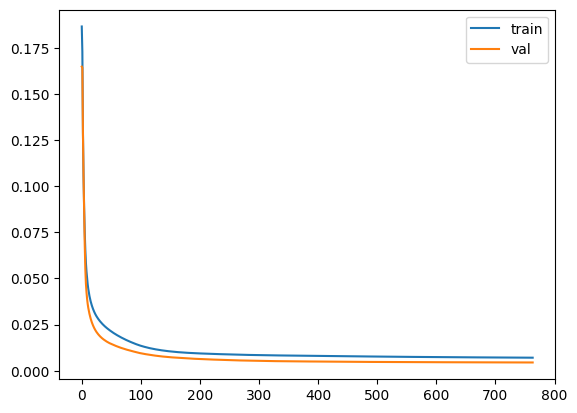

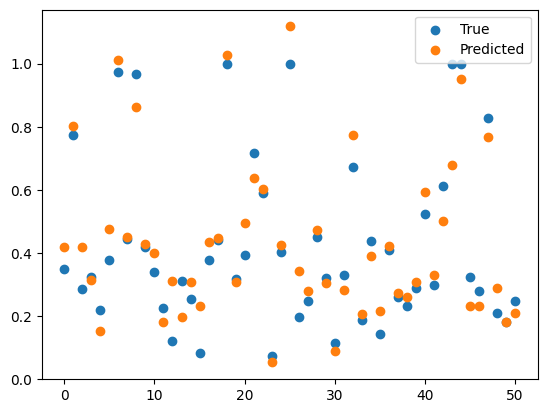

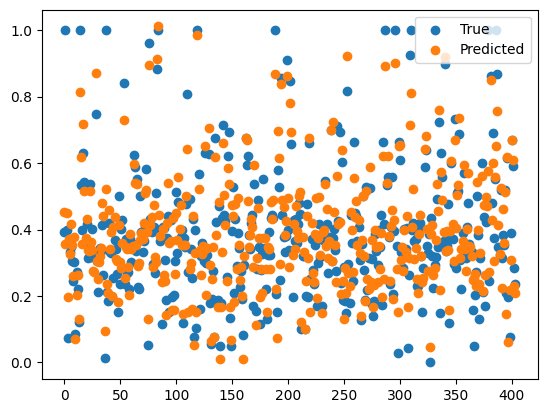

In [201]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(mlp.loss, label='train')
plt.plot(mlp.history, label='val')
plt.legend()
plt.show()

# Plot the data
plt.scatter(range(len(y_test)), y_test, label='True')
plt.scatter(range(len(y_test)), mlp.predict(X_test), label='Predicted')
plt.legend()
plt.show()

# plot the train
plt.scatter(range(len(y_train)), y_train, label='True')
plt.scatter(range(len(y_train)), mlp.predict(X_train), label='Predicted')
plt.legend()
plt.show()



# MSE vs BEC

In [202]:
# load the data
filepath = '../../data/interim/diabetes_normalized.csv'

df = pd.read_csv(filepath)

X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values
y = y.reshape(-1, 1)

print(X.shape, y.shape)

# shuffle the data
np.random.seed(0)

idx = np.random.permutation(len(X))

X = X[idx]
y = y[idx]

# split the data
X_train = X[:int(0.8*len(X))]
X_test = X[int(0.8*len(X)):int(0.9*len(X))]
X_val = X[int(0.9*len(X)):]

y_train = y[:int(0.8*len(y))].astype(int)
y_test = y[int(0.8*len(y)):int(0.9*len(y))].astype(int)
y_val = y[int(0.9*len(y)):].astype(int)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)


(768, 8) (768, 1)
(614, 8) (77, 8) (77, 8)
(614, 1) (77, 1) (77, 1)


In [203]:
# Initialize the model
mlp = MLP(input_size = X_train.shape[1], hidden_layers = [1], output_size = 2, epochs = 1000, learning_rate = 1,batch_size=4,
            activation_function = 'sigmoid', loss_function = 'cross_entropy', optimizer = 'mini_batch', Random_state = 6, weight_init = 'he',
            model_type = 'class_MC', wandb_vaar = False)

# prepare the target variable
y_train_oh = mlp._one_hot(y_train)
y_test_oh = mlp._one_hot(y_test)
y_val_oh = mlp._one_hot(y_val)

# Train the model
mlp.fit(X_train, y_train_oh, X_val, y_val_oh)

Converged after 18 epochs


In [210]:
# Evaluate the model
loss = mlp.evaluate(X_test, y_test_oh)

# check prediction
y_pred = mlp.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_oh, axis=1)

print(y_pred)
print(y_test_arg)

# save mse for every single data point
mse = ((y_test_arg - y_pred)**2)
print(f"Test loss: {loss}")
print(f"Test mse: {mse}")

# print accuracy
accuracy = mlp.accuracy(y_test_arg, y_pred)
print(f"Test accuracy: {accuracy}")

[0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1
 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 1 0
 0 1 0]
[0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1
 0 1 0]
Test loss: 0.19261641528709272
Test mse: [0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1
 0 0 0]
Test accuracy: 0.6753246753246753


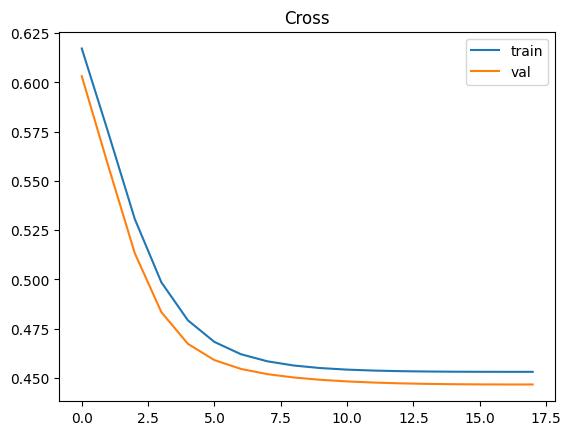

In [205]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(mlp.loss, label='train')
plt.plot(mlp.history, label='val')
plt.title('Cross')
plt.legend()
plt.show()


In [206]:
# use mse
# Initialize the model
mlp = MLP(input_size = X_train.shape[1], hidden_layers = [1], output_size = 2, epochs = 1000, learning_rate = 1,batch_size=4,
            activation_function = 'sigmoid', loss_function = 'mse', optimizer = 'mini_batch', Random_state = None, weight_init = 'he',
            model_type = 'class_MC', wandb_vaar = False)

# fit
mlp.fit(X_train, y_train_oh, X_val, y_val_oh)

Converged after 29 epochs


In [215]:
# Evaluate the model
loss = mlp.evaluate(X_test, y_test_oh)

# check prediction
y_pred = mlp.predict(X_test)

# calculate mse for every single data point
mse = ((y_test_oh - y_pred)**2)
# add y_test_oh and y_pred and mse to csv file save both columns
df = pd.DataFrame(data={'y_test_oh':y_test_oh[:,0], 'y_pred':y_pred[:,0], 'mse':mse[:,0]})
df.to_csv('diabetes_mse.csv', index=False)

y_pred = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_oh, axis=1)

print(y_pred)
print(y_test_arg)

# print accuracy
accuracy = mlp.accuracy(y_test_arg, y_pred)
print(f"Test accuracy: {accuracy}")

[0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1
 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 1 0
 0 1 0]
[0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1
 0 1 0]
Test accuracy: 0.6753246753246753


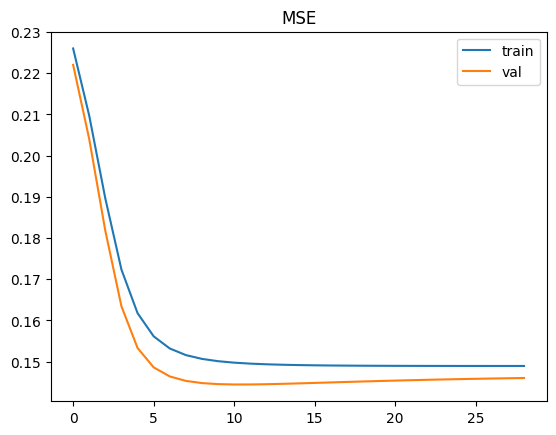

In [208]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(mlp.loss, label='train')
plt.plot(mlp.history, label='val')
plt.title('MSE')
plt.legend()
plt.show()


To compare the convergence between MSE (Mean Squared Error) and Cross (likely referring to Cross-entropy) loss functions, I'll analyze both plots and note the key observations and differences:

1. Initial values:
- MSE starts around 0.23
- Cross starts much higher, around 0.62

2. Rate of decline:
- Both show a rapid initial decrease
- MSE's decline is steeper in the very beginning
- Cross has a more gradual but consistent decline 

3. Convergence point:
- MSE converges around epoch 29
- Cross seems to converge later, around epoch 18

4. Final values:
- MSE converges to about 0.15
- Cross converges to about 0.45

5. Train vs. Validation:
- In both plots, the validation loss (orange) is slightly lower than the training loss (blue)
- This gap is more pronounced in the Cross plot

6. Smoothness:
- MSE plot is smoother overall
- Cross plot shows more fluctuations, especially in the validation line

7. Overfitting:
- Neither plot shows clear signs of overfitting, as validation loss doesn't increase

8. Scale of improvement:
- MSE improves from ~0.23 to ~0.15, a reduction of about 35%
- Cross improves from ~0.62 to ~0.45, a reduction of about 27%

Key differences:
1. Scale: Cross loss operates on a larger scale than MSE
2. Convergence speed: Cross converges slightly faster
3. Stability: MSE appears more stable, with less fluctuation
4. Train-validation gap: More pronounced in the Cross plot

In both cases, the models seem to be learning effectively without obvious overfitting. The Cross loss might be more sensitive to small changes in the model's predictions, explaining its greater fluctuations. The consistent gap between train and validation loss in the Cross plot could indicate that the model generalizes well, possibly even slightly better than with MSE.